<a href="https://colab.research.google.com/github/RodLunardi/predicciones_de_ventas_alimenticias/blob/main/Proyecto_1_Final(b%C3%A1sico).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
filename = "/content/sales_predictions(11).csv"
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Pré-procesamineto de la Data

In [ ]:
#Filas Duplicadas
df.duplicated().sum() 

0

In [ ]:
df_1 = df.copy()
df_1
df_1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Para los valores faltantes de la columna 'Item_Weight' se aplicou la funcion fillna() combinada con la función groupby. ya que decidí rellenar los valores faltantes con el promedio del peso por el identificador. Para los valores faltantes de la columna 'Outlet_Size'. Considerando que la columna es categorica, para rellenar los valores faltantes se aplicou la funcion fillna() dentro de la función applay(lambda) combinada con la función groupby para rellenar con la moda() del tamaño del Outlet por el tipo de Outlet. Essa estrategia es para eliminar los valores nulos sin eliminar columnas o filas del dataframe. Las 4 filas que continuaron vacias despues de abordar los datos faltantes fueron eliminadas por reprentar una minima parte del dataframe

In [ ]:
df_1['Item_Weight'].fillna(df_1.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'), inplace=True)
df_1['Outlet_Size'] = df_1.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.fillna(x.mode()[0]))
df_1['Item_Fat_Content'] = df_1['Item_Fat_Content'].replace('LF', 'Low Fat')
df_1['Item_Fat_Content'] = df_1['Item_Fat_Content'].replace('low fat', 'Low Fat')
df_1['Item_Fat_Content'] = df_1['Item_Fat_Content'].replace('reg', 'Regular')
df_1.dropna(subset=['Item_Weight'], inplace=True)

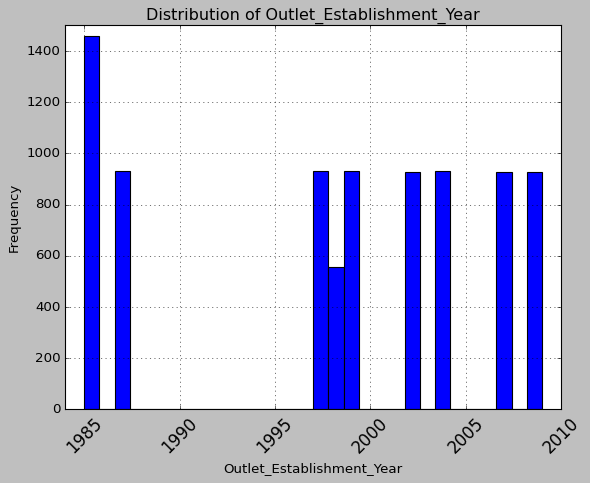

In [ ]:
plt.style.use('classic')
df_1['Outlet_Establishment_Year'].hist(bins = 30, edgecolor='black')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks(rotation = 45, fontsize=15)
plt.title('Distribution of Outlet_Establishment_Year')
plt.xlabel('Outlet_Establishment_Year')
plt.ylabel('Frequency')
plt.xlim(left=1984,right=2010)
plt.ylim(bottom=0,top=1500)
plt.show()

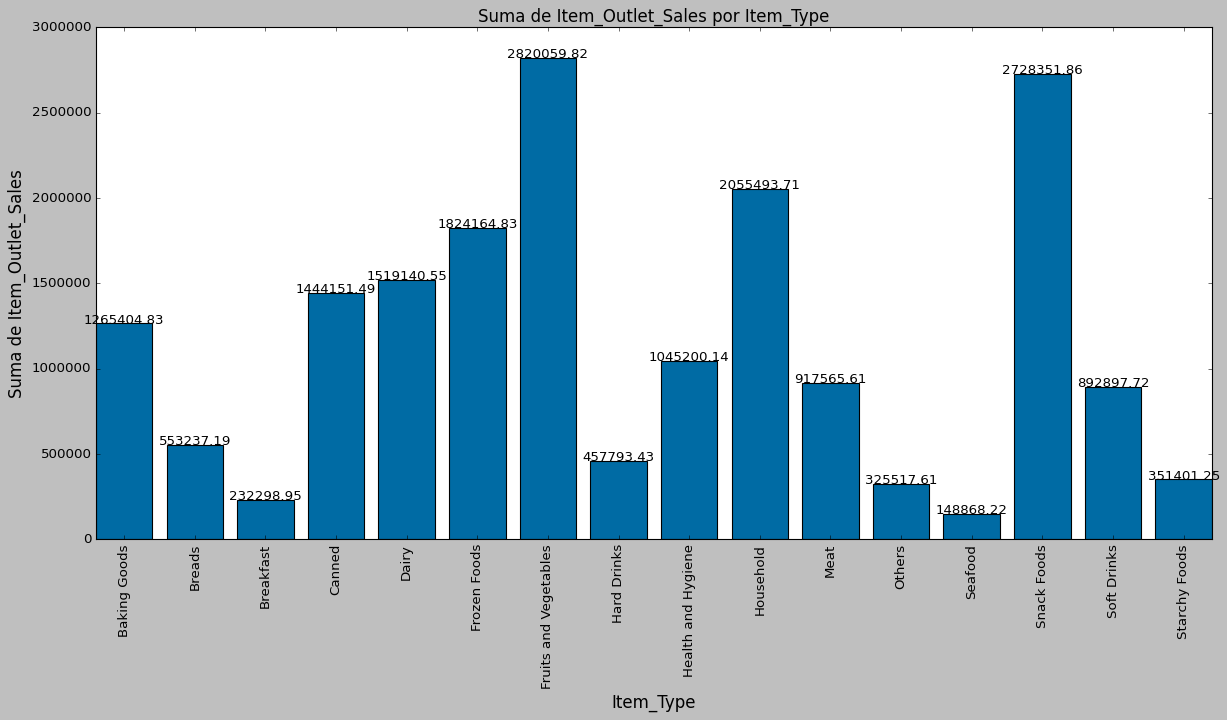

In [ ]:
plt.style.use('tableau-colorblind10')
sum_ventas = df_1.groupby('Item_Type')['Item_Outlet_Sales'].sum().round(2)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (18,8))
plt.bar(sum_ventas.index, sum_ventas.values)
for i, v in enumerate(sum_ventas.values):
    plt.text(i, v + 2, str(v), ha='center') 
# Etiquetar los ejes x e y y darle un título al gráfico
plt.xticks(rotation = 90)
plt.xlabel('Item_Type', fontsize=15)
plt.ylabel('Suma de Item_Outlet_Sales', fontsize=15)
plt.title('Suma de Item_Outlet_Sales por Item_Type', fontsize=15)
# Mostrar el gráfico
plt.show()

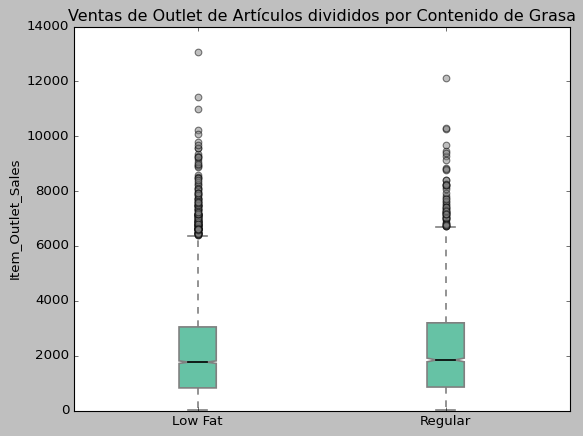

In [ ]:
# Dividir los datos por valores de Item_Fat_Content
low_fat_data = df_1[df_1['Item_Fat_Content'] == 'Low Fat']['Item_Outlet_Sales']
regular_data = df_1[df_1['Item_Fat_Content'] == 'Regular']['Item_Outlet_Sales']
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))
# Crear el boxplot
# Configurar las propiedades del boxplot
bp = ax.boxplot([low_fat_data, regular_data], notch=True, patch_artist=True, 
                boxprops=dict(facecolor='#66c2a5', color='gray', linewidth=1.5), 
                whiskerprops=dict(color='gray', linewidth=1.5, linestyle='--'), 
                capprops=dict(color='gray', linewidth=1.5), 
                medianprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', color='gray', alpha=0.5))
# Configurar los ejes y el título
ax.set_xticklabels(['Low Fat', 'Regular'])
ax.set_ylabel('Item_Outlet_Sales')
ax.set_title('Ventas de Outlet de Artículos divididos por Contenido de Grasa')
# Mostrar el gráfico
plt.show()

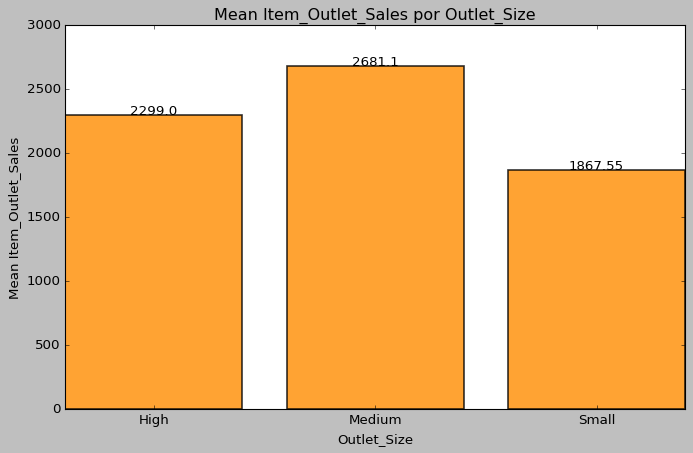

In [ ]:
mean_filter = df_1.groupby(['Outlet_Size'])['Item_Outlet_Sales'].mean().round(2)
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('tableau-colorblind10')
plt.bar(mean_filter.index, mean_filter.values, color='#FF8C00', edgecolor='k', linewidth=1.5, alpha=0.8)
for i, v in enumerate(mean_filter.values):
    plt.text(i, v + 1, str(v), ha='center') # codigo para colocar montos correspondiente a las barras
ax.set_title('Mean Item_Outlet_Sales por Outlet_Size')
ax.set_xlabel('Outlet_Size')
ax.set_ylabel('Mean Item_Outlet_Sales')
plt.show()

In [ ]:
#inspect the data
print(df.info(), '\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

Item_Identifier                 0
Item

In [ ]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

<ipython-input-13-61162683eb85>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


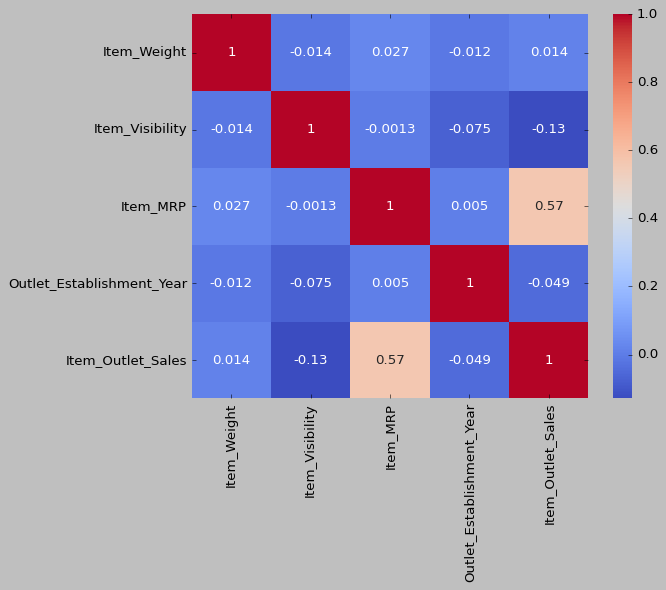

Características con una correlación de magnitud 0.5 o mayor con el precio: ['Item_MRP', 'Item_Outlet_Sales']


In [ ]:
# Generar matriz de correlaciones
corr_matrix = df.corr()
# Crear mapa de calor
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
# Mostrar mapa de calor
plt.show()
# Obtener las características que tienen una correlación de magnitud 0,5 o mayor con el precio
corr_threshold = 0.5
price_corr_features = corr_matrix[(corr_matrix['Item_Outlet_Sales'] >= corr_threshold) | (corr_matrix['Item_Outlet_Sales'] <= -corr_threshold)].index.tolist()
# Imprimir las características encontradas
print("Características con una correlación de magnitud {} o mayor con el precio: {}".format(corr_threshold, price_corr_features))

In [ ]:
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype(str)

In [ ]:
df = df.drop(columns=['Item_Identifier'])

In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [ ]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Scaler
scaler = StandardScaler()
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe
# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor
# fit on train
preprocessor.fit(X_train)
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_df = pd.DataFrame(X_train_processed)
X_test_df = pd.DataFrame(X_test_processed)
X_train_df.columns=preprocessor.get_feature_names_out()
X_test_df.columns=preprocessor.get_feature_names_out()
X_train_df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-2__Item_Fat_Content_Low Fat,pipeline-2__Item_Fat_Content_Regular,pipeline-2__Item_Type_Baking Goods,pipeline-2__Item_Type_Breads,pipeline-2__Item_Type_Breakfast,pipeline-2__Item_Type_Canned,pipeline-2__Item_Type_Dairy,...,pipeline-2__Outlet_Size_High,pipeline-2__Outlet_Size_Medium,pipeline-2__Outlet_Size_Small,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
0,0.817249,-0.712775,1.828109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.556340,-1.291052,0.603369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.131512,1.813319,0.244541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.169219,-1.004931,-0.952591,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.528819,-0.965484,-0.336460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#inspect the data
print(X_train_df.info(), '\n')
print(X_train_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 50 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pipeline-1__Item_Weight                      6392 non-null   float64
 1   pipeline-1__Item_Visibility                  6392 non-null   float64
 2   pipeline-1__Item_MRP                         6392 non-null   float64
 3   pipeline-2__Item_Fat_Content_Low Fat         6392 non-null   float64
 4   pipeline-2__Item_Fat_Content_Regular         6392 non-null   float64
 5   pipeline-2__Item_Type_Baking Goods           6392 non-null   float64
 6   pipeline-2__Item_Type_Breads                 6392 non-null   float64
 7   pipeline-2__Item_Type_Breakfast              6392 non-null   float64
 8   pipeline-2__Item_Type_Canned                 6392 non-null   float64
 9   pipeline-2__Item_Type_Dairy                  6392 non-null   float64
 10  

En el pré-procesamiento la columna "Item_Identifier" no tiene una relación significativa con la variable objetivo, decidí eliminarla por no afectar significativamente la capacidad del modelo para predecir la variable objetivo. tambien converti la columna 'Outlet_Establishment_Year' en object por que consideré los valores como categoricos, pese que son numeros, en la columna 'Item_Fat_Content' sustituí valores unicos que representan la misma categoria por un solo nombre( Low Fat, estaba escrito de 3 formas distintas)
Identifiqué el objetivo (X) y las características (y): Asigneé la columna "Item_Outlet_Sales" como el objetivo y el resto de las variables relevantes como el matriz de características, Realice un train test split, Cree un pipeline de preprocesamiento para preparar el conjunto de datos para el aprendizaje automático, 

1) La primera tarea será crear un modelo de regresión lineal para predecir las ventas.

Creen un modelo de regresión lineal.

Evalúen el rendimiento del modelo basándose en r^2.

Evalúen el rendimiento del modelo basándose en RECM.

In [ ]:
# Make a linear regression instance
reg = LinearRegression()
#Entrenar el modelo en los datos de entrenamiento. Este es el paso donde el modelo “aprender” sobre la relación entre las características y el objetivo.
reg.fit(X_train_df,y_train)
# Obtengan las predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train_df)
# Obtengan las predicciones del conjunto de prueba
test_preds = reg.predict(X_test_df)

In [ ]:
#A continuación, se muestra el código para obtener los datos de R^2 después de ajustar nuestro modelo: 
train_score = reg.score(X_train_df, y_train)
print(train_score)
test_score = reg.score(X_test_df, y_test)
print(test_score)

0.5615547614077183
0.5671059423458024


In [ ]:
#Raíz del error cuadrático medio (RECM): raíz cuadrada de la media de los errores al cuadrado. 
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print(rmse_train)
print(rmse_test)

1139.1045880315098
1092.8608663020173


2) La segunda tarea será crear un modelo de árbol de regresión para predecir las ventas.

Creen un modelo simple de árbol de regresión.

Comparen el rendimiento del modelo basándose en r^2.

Comparen el rendimiento del modelo basándose en RECM.  

In [ ]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_df, y_train)
train_preds_1 = dec_tree.predict(X_train_df)
test_preds_1 = dec_tree.predict(X_test_df)
train_score = dec_tree.score(X_train_df, y_train)
test_score = dec_tree.score(X_test_df, y_test)
print(train_score)
print(test_score)

1.0
0.14712067408106144


In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
# ¿Cuál era la profundidad de nuestro árbol por defecto?
dec_tree.get_depth()

44

In [ ]:
# ¿Cuántos nodos hojas?
dec_tree.get_n_leaves()

6270

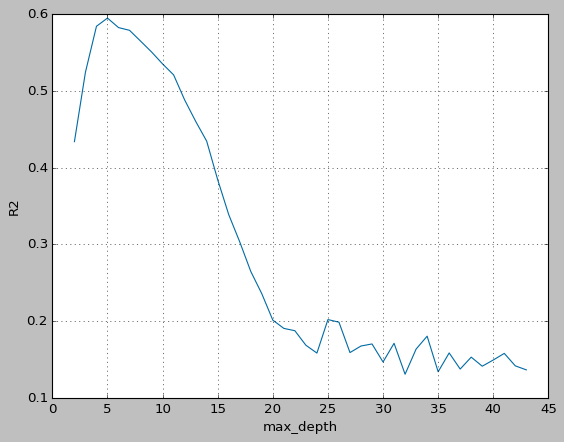

In [ ]:
# Lista de valores a probar para max_depth:
max_depth_range = list(range(2, 44))# will try every value between 2 and 36
# Lista para almacenar la puntuación para cada valor de max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train_df, y_train)
    score = dec_tree.score(X_test_df, y_test)
    r2.append(score)
# Visualicen qué max_depth lleva a una puntuación R2 más alta
plt.plot(max_depth_range, r2)
plt.grid(True)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [ ]:
# Ejecutemos el modelo con nuestro valor optimizado para max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_df, y_train)
train_preds_1 = dec_tree.predict(X_train_df)
test_preds_1 = dec_tree.predict(X_test_df)
train_5_score = dec_tree_5.score(X_train_df, y_train)
test_5_score = dec_tree_5.score(X_test_df, y_test)
print(train_5_score)
print(test_5_score)

0.6039397477322958
0.5947099753159973


In [ ]:
#A continuación, se muestra el código para obtener los datos de R^2 después de ajustar nuestro modelo: 
train_5_score = reg.score(X_train_df, y_train)
print(train_5_score)
test_5_score = reg.score(X_test_df, y_test)
print(test_5_score)

0.5615547614077183
0.5671059423458024


In [ ]:
#Raíz del error cuadrático medio (RECM): raíz cuadrada de la media de los errores al cuadrado. 
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds_1))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds_1))
print(rmse_train)
print(rmse_test)

0.247320263329386
1543.3828318759754


In [ ]:
#Bagged Trees en Python
bagreg = BaggingRegressor(random_state = 42)
# Miren a los hiperparámetros
bagreg.get_params()
#El modelo está aprendiendo la relación entre X e y. ¡Esto puede tomar un tiempo para ejecutar!
bagreg.fit(X_train_df, y_train)
#Paso 4: predecir los valores para y (recuerden que este paso permite 
#ver las predicciones reales, pero no es necesario para evaluar o afinar el modelo).
bagreg.predict(X_test_df)
#Paso 5: evaluar el rendimiento del modelo
bagreg_train_score = bagreg.score(X_train_df, y_train)
bagreg_test_score = bagreg.score(X_test_df, y_test)
print(bagreg_train_score)
print(bagreg_test_score)

0.9194301494633378
0.5368263337309715


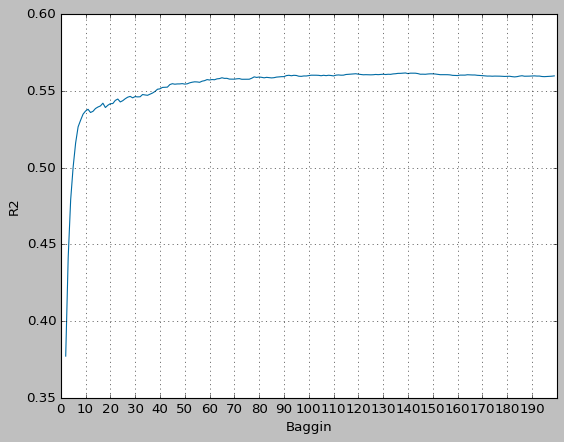

In [ ]:
# Lista de valores a probar para max_depth:
max_estimators_range = list(range(2, 200))# will try every value between 2 and 200
# Lista para almacenar la puntuación para cada valor de max_depth:
r2 = []
for estimator in max_estimators_range:
    bagging_regresor = BaggingRegressor(n_estimators = estimator, 
                             random_state = 42)
    bagging_regresor.fit(X_train_df, y_train)
    score = bagging_regresor.score(X_test_df, y_test)
    r2.append(score)
# Visualicen qué max_depth lleva a una puntuación R2 más alta
plt.plot(max_estimators_range, r2)
plt.xlabel('Baggin')
plt.xticks(np.arange(0,200,10))
plt.grid(True)
plt.ylabel('R2');

In [ ]:
for i in range(len(r2)):
  if (r2[i]==max(r2)):
      break
print("Estimadores", max_estimators_range[i])

Estimadores 139


In [ ]:
# Ejecutemos el modelo con nuestro valor optimizado para estimators
#Bagged Trees en Python
bagreg_139 = BaggingRegressor(n_estimators=139, random_state = 42)
# Miren a los hiperparámetros
bagreg_139.get_params()
#El modelo está aprendiendo la relación entre X e y. ¡Esto puede tomar un tiempo para ejecutar!
bagreg_139.fit(X_train_df, y_train)
#Paso 4: predecir los valores para y (recuerden que este paso permite 
#ver las predicciones reales, pero no es necesario para evaluar o afinar el modelo).
bagreg_139.predict(X_train_df)
bagreg_139.predict(X_test_df)
#Paso 5: evaluar el rendimiento del modelo
bagreg_139_train_score = bagreg_139.score(X_train_df, y_train)
bagreg_139_test_score = bagreg_139.score(X_test_df, y_test)
print(bagreg_139_train_score)
print(bagreg_139_test_score)

0.9389079825962254
0.5616113033712411


In [ ]:
#A continuación, se muestra el código para obtener los datos de R^2 después de ajustar nuestro modelo: 
bagreg_139_train_score = reg.score(X_train_df, y_train)
print(bagreg_139_train_score)
bagreg_139_test_score = reg.score(X_test_df, y_test)
print(bagreg_139_test_score)

0.5615547614077183
0.5671059423458024


In [ ]:
#Raíz del error cuadrático medio (RECM): raíz cuadrada de la media de los errores al cuadrado. 
train_bagreg_preds = bagreg_139.predict(X_train_df)
test_bagreg_preds = bagreg_139.predict(X_test_df)
rmse_train = np.sqrt(mean_squared_error(y_train, train_bagreg_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_bagreg_preds))
print(rmse_train)
print(rmse_test)

425.2047970174332
1099.7747302197427


3) Acaban de intentar 2 diferentes modelos en el conjunto de datos. Deben determinar qué modelo implementar.

En general, ¿qué modelo recomiendan?
Justifiquen su recomendación.

En el caso del modelo de regresión lineal, el RECM en el conjunto de prueba es de 1139.1045880315098, mientras que en el caso del modelo de árbol de regresión el RECM es de 0.24. A partir de estos resultados, podemos concluir que el modelo de árbol de regresión es mejor que el modelo de regresión lineal, ya que tiene un RECM menor en el conjunto de prueba. 